## Setup

In [68]:
%matplotlib inline

In [69]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [70]:
from aif360.datasets import StandardDataset
# StandardDataset??

In [71]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from metrics_utils import get_orig_model_metrics
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias

## Arguments & Initializations

In [72]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [73]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [74]:
DATASET = "law_race"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [75]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [76]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False
else:
    SCALER = False
DISPLAY = False
THRESH_ARR = 0.5

# loop ten times
N = 3

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list)
transf_mia_metrics = defaultdict(list)

reweigh_metrics = defaultdict(list)
reweigh_mia_metrics = defaultdict(list)

dir_metrics = defaultdict(list)
dir_mia_metrics = defaultdict(list)

egr_metrics = defaultdict(list)
egr_mia_metrics = defaultdict(list)


pr_orig_metrics = defaultdict(list)
cpp_metrics = defaultdict(list)
ro_metrics = defaultdict(list)

## Loading & Splitting Dataset

In [77]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

In [78]:
dataset_orig.features.shape

(20798, 13)

In [79]:
# Assuming dataset_orig is your BinaryLabelDataset object
race_labels = dataset_orig.labels.flatten()

# Count the number of race = 1 and race = 0
pd.Series(race_labels).value_counts()

1.0    19758
0.0     1040
Name: count, dtype: int64

In [80]:
privileged_groups

[{'race': 1}]

In [81]:
unprivileged_groups

[{'race': 0}]

In [82]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[2. 2. 0. ... 4. 6. 8.]
 [3. 2. 0. ... 3. 2. 2.]
 [8. 8. 0. ... 6. 6. 8.]
 ...
 [9. 8. 0. ... 5. 6. 8.]
 [6. 6. 0. ... 3. 5. 5.]
 [5. 9. 0. ... 3. 5. 5.]]


In [83]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [84]:
dataset_orig_train

               instance weights features features            features  \
                                                  protected attribute   
                                 decile3  decile1                race   
instance names                                                          
85                          1.0      2.0      2.0                 0.0   
14508                       1.0      3.0      2.0                 0.0   
12515                       1.0      8.0      8.0                 0.0   
7320                        1.0      1.0      1.0                 0.0   
8399                        1.0      2.0      2.0                 0.0   
...                         ...      ...      ...                 ...   
12585                       1.0      6.0      7.0                 0.0   
12960                       1.0      2.0      3.0                 0.0   
3621                        1.0      9.0      8.0                 0.0   
6123                        1.0      6.0      6.0  

In [85]:
dataset_orig_train?

## Run Mitigating Algorithms

In [86]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False))
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True)
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False)
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)

    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    train_test_egr, egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

#### Train dataset's features are as below:
[[ 9.  9.  0. ...  2.  6.  6.]
 [ 1.  1.  0. ...  6.  4.  4.]
 [ 9. 10.  0. ...  4.  6.  8.]
 ...
 [ 2.  4.  0. ...  2.  6.  7.]
 [ 6.  8.  0. ...  4.  6.  8.]
 [ 1.  1.  0. ...  4.  2.  2.]]
no bias type specified
#### Training Dataset shape
(10399, 13)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['race']
#### Privileged and unprivileged protected groups
[{'race': 1}] [{'race': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['decile3', 'decile1', 'race', 'cluster', 'lsat', 'ugpa', 'dob_yr', 'fulltime', 'fam_inc', 'gender', 'tier', 'indxgrp', 'indxgrp2']
privileged vs. unprivileged:  466.0 9933.0
base_pos unpriv:  0.9488573442061814
base_pos priv:  0.8540772532188842
number of favorable labels:  9823
Difference in mean outcomes between unprivileged and privileged groups = 0.094780
#### Train shape, validation shape, test shape
(10399, 13) 

Accuracy for threshold: 0.060000000000000005  is: 0.9427829598999904
Balanced accuracy is:  0.5416883232389844
Accuracy for threshold: 0.06999999999999999  is: 0.9427829598999904
Balanced accuracy is:  0.5416883232389844
Accuracy for threshold: 0.08  is: 0.9427829598999904
Balanced accuracy is:  0.5416883232389844
Accuracy for threshold: 0.09  is: 0.9427829598999904
Balanced accuracy is:  0.5416883232389844
Accuracy for threshold: 0.09999999999999999  is: 0.9427829598999904
Balanced accuracy is:  0.5416883232389844
Accuracy for threshold: 0.11  is: 0.9427829598999904
Balanced accuracy is:  0.5416883232389844
Accuracy for threshold: 0.12  is: 0.9427829598999904
Balanced accuracy is:  0.5416883232389844
Accuracy for threshold: 0.13  is: 0.9427829598999904
Balanced accuracy is:  0.5416883232389844
Accuracy for threshold: 0.14  is: 0.9427829598999904
Balanced accuracy is:  0.5416883232389844
Accuracy for threshold: 0.15000000000000002  is: 0.9427829598999904
Balanced accuracy is:  0.543742

[INFO]: training decision tree
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.86      0.52      0.64       576
         1.0       0.97      1.00      0.98      9823

    accuracy                           0.97     10399
   macro avg       0.92      0.76      0.81     10399
weighted avg       0.97      0.97      0.96     10399

Train accuracy:  0.968554668718146
Validating Original ...
Accuracy for threshold: 0.01  is: 0.9422059813443601
Balanced accuracy is:  0.5537134694479635
Accuracy for threshold: 0.02  is: 0.9422059813443601
Balanced accuracy is:  0.5537134694479635
Accuracy for threshold: 0.03  is: 0.9422059813443601
Balanced accuracy is:  0.5537134694479635
Accuracy for threshold: 0.04  is: 0.9422059813443601
Balanced accuracy is:  0.5537134694479635
Accuracy for threshold: 0.05  is: 0.9422059813443601
Balanced accuracy is:  0.5537134694479635
Accuracy for threshold: 0.060000000000000005  is: 0.942

Accuracy for threshold: 0.12  is: 0.943744590826041
Balanced accuracy is:  0.5504096671467991
Accuracy for threshold: 0.13  is: 0.9434561015482258
Balanced accuracy is:  0.5523132039289866
Accuracy for threshold: 0.14  is: 0.9434561015482258
Balanced accuracy is:  0.5523132039289866
Accuracy for threshold: 0.15000000000000002  is: 0.9434561015482258
Balanced accuracy is:  0.5523132039289866
Accuracy for threshold: 0.16  is: 0.9434561015482258
Balanced accuracy is:  0.5523132039289866
Accuracy for threshold: 0.17  is: 0.9434561015482258
Balanced accuracy is:  0.5543677220901376
Accuracy for threshold: 0.18000000000000002  is: 0.9434561015482258
Balanced accuracy is:  0.5543677220901376
Accuracy for threshold: 0.19  is: 0.9434561015482258
Balanced accuracy is:  0.5543677220901376
Accuracy for threshold: 0.2  is: 0.9434561015482258
Balanced accuracy is:  0.5543677220901376
Accuracy for threshold: 0.21000000000000002  is: 0.9434561015482258
Balanced accuracy is:  0.5543677220901376
Accurac

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.07664198480623137
Balanced accuracy is:  0.36986088454263055
Accuracy for threshold: 0.02  is: 0.07664198480623137
Balanced accuracy is:  0.36986088454263055
Accuracy for threshold: 0.03  is: 0.07664198480623137
Balanced accuracy is:  0.36986088454263055
Accuracy for threshold: 0.04  is: 0.07664198480623137
Balanced accuracy is:  0.36986088454263055
Accuracy for threshold: 0.05  is: 0.07664198480623137
Balanced accuracy is:  0.36986088454263055
Accuracy for threshold: 0.060000000000000005  is: 0.07664198480623137
Balanced accuracy is:  0.36986088454263055
Accuracy for threshold: 0.06999999999999999  is: 0.07664198480623137
Balanced accuracy is:  0.36986088454263055
Accuracy for threshold: 0.08  is: 0.07664198480623137
Balanced accuracy is:  0.36986088454263055
Accuracy for threshold: 0.09  is: 0.07664198480623137
Balanced accuracy is:  0.36986088454263055
Accuracy for threshold: 0.09999999999999999  is: 0.07664198480623137
Balanced accur

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 508
Number of test samples (ntest): 416
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9425
Number of test samples (ntest): 9516
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 68
Number of test samples (ntest): 48
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 398
Number of test samples (ntest): 419
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.4638365518675808
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 576, Test = 464
  AUC: 0.69
  Privacy Risk: 0.66
  Accuracy: 0.66
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.33
  Positive predictive value: 

Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9451
Number of test samples (ntest): 9490
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 59
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 418
Number of test samples (ntest): 399
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -2.639057329615259
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.74
  Privacy Risk: 0.69
  Accuracy: 0.70
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.39
  Positive predictive value: 0.71
  Optimal thershold: -2.639057329615259
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 473
Number of test samples (ntest): 451
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9451
Number of test samples (ntest): 9490
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 59
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 418
Number of test samples (ntest): 399
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -2.639057329615259
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.73
  Privacy Risk: 0.69
  Accuracy: 0.70
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.39
  Positive predictive value: 0

Number of training samples (ntrain): 9451
Number of test samples (ntest): 9490
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 59
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 418
Number of test samples (ntest): 399
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.54
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.05
  Positive predictive value: 0.56
  Optimal thershold: -0.03846628082779605
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.75
  Privacy Risk: 0.69
  Accuracy: 0.69
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.68
  Attacker advantage: 0.39
  Positive predictive value: 0.74
  Optimal thershold: -1.7917594692280552
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 9869, Test = 9889
  AU

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 473
Number of test samples (ntest): 451
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 9451
Number of test samples (ntest): 9490
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 57
Number of test samples (ntest): 59
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 418
Number of test samples (ntest): 399
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 10399, Test = 10399
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -2.604180392066265
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 530, Test = 510
  AUC: 0.75
  Privacy Risk: 0.70
  Accuracy: 0.71
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.41
  Positive predictive value: 0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.02  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.03  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.04  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.05  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.060000000000000005  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.06999999999999999  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.08  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.09  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.09999999999999999  is: 0.06442927204538898
Balanced accur

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

              precision    recall  f1-score   support

         0.0       1.00      0.19      0.32       451
         1.0       0.00      0.00      0.00         0

    accuracy                           0.19       451
   macro avg       0.50      0.10      0.16       451
weighted avg       1.00      0.19      0.32       451

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99      9490

    accuracy                           0.98      9490
   macro avg       0.50      0.49      0.50      9490
weighted avg       1.00      0.98      0.99      9490

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.27      0.43        59
         1.0       0.00      0.00      0.00         0

    accuracy                           0.27        59
   macro avg       0.50      0.14      0.21        59
weight

Accuracy for threshold: 0.23  is: 0.9417251658813347
Balanced accuracy is:  0.5825502291117681
Accuracy for threshold: 0.24000000000000002  is: 0.9417251658813347
Balanced accuracy is:  0.5825502291117681
Accuracy for threshold: 0.25  is: 0.9417251658813347
Balanced accuracy is:  0.5825502291117681
Accuracy for threshold: 0.26  is: 0.9417251658813347
Balanced accuracy is:  0.5825502291117681
Accuracy for threshold: 0.27  is: 0.9417251658813347
Balanced accuracy is:  0.5825502291117681
Accuracy for threshold: 0.28  is: 0.9417251658813347
Balanced accuracy is:  0.5825502291117681
Accuracy for threshold: 0.29000000000000004  is: 0.9417251658813347
Balanced accuracy is:  0.5825502291117681
Accuracy for threshold: 0.3  is: 0.9417251658813347
Balanced accuracy is:  0.5825502291117681
Accuracy for threshold: 0.31  is: 0.9417251658813347
Balanced accuracy is:  0.5825502291117681
Accuracy for threshold: 0.32  is: 0.9417251658813347
Balanced accuracy is:  0.5825502291117681
Accuracy for threshol

Accuracy for threshold: 0.12  is: 0.9424944706221752
Balanced accuracy is:  0.58016522616732
Accuracy for threshold: 0.13  is: 0.9424944706221752
Balanced accuracy is:  0.58016522616732
Accuracy for threshold: 0.14  is: 0.9424944706221752
Balanced accuracy is:  0.58016522616732
Accuracy for threshold: 0.15000000000000002  is: 0.9423983075295701
Balanced accuracy is:  0.5801146649376708
Accuracy for threshold: 0.16  is: 0.9423983075295701
Balanced accuracy is:  0.5801146649376708
Accuracy for threshold: 0.17  is: 0.9415328396961247
Balanced accuracy is:  0.5805894447980425
Accuracy for threshold: 0.18000000000000002  is: 0.9415328396961247
Balanced accuracy is:  0.5805894447980425
Accuracy for threshold: 0.19  is: 0.9415328396961247
Balanced accuracy is:  0.5805894447980425
Accuracy for threshold: 0.2  is: 0.9416290027887297
Balanced accuracy is:  0.582499667882119
Accuracy for threshold: 0.21000000000000002  is: 0.9416290027887297
Balanced accuracy is:  0.582499667882119
Accuracy for t

Accuracy for threshold: 0.29000000000000004  is: 0.9415328396961247
Balanced accuracy is:  0.5722209664531198
Accuracy for threshold: 0.3  is: 0.940571208770074
Balanced accuracy is:  0.5717153541566288
Accuracy for threshold: 0.31  is: 0.940571208770074
Balanced accuracy is:  0.5717153541566288
Accuracy for threshold: 0.32  is: 0.940571208770074
Balanced accuracy is:  0.5717153541566288
Accuracy for threshold: 0.33  is: 0.940571208770074
Balanced accuracy is:  0.5717153541566288
Accuracy for threshold: 0.34  is: 0.940571208770074
Balanced accuracy is:  0.5717153541566288
Accuracy for threshold: 0.35000000000000003  is: 0.940571208770074
Balanced accuracy is:  0.5717153541566288
Accuracy for threshold: 0.36000000000000004  is: 0.940571208770074
Balanced accuracy is:  0.5717153541566288
Accuracy for threshold: 0.37  is: 0.940571208770074
Balanced accuracy is:  0.5717153541566288
Accuracy for threshold: 0.38  is: 0.940571208770074
Balanced accuracy is:  0.5717153541566288
Accuracy for th

Accuracy for threshold: 0.19  is: 0.9430714491778056
Balanced accuracy is:  0.5730299461275056
Accuracy for threshold: 0.2  is: 0.9430714491778056
Balanced accuracy is:  0.5730299461275056
Accuracy for threshold: 0.21000000000000002  is: 0.9430714491778056
Balanced accuracy is:  0.5730299461275056
Accuracy for threshold: 0.22  is: 0.9430714491778056
Balanced accuracy is:  0.5730299461275056
Accuracy for threshold: 0.23  is: 0.9430714491778056
Balanced accuracy is:  0.5730299461275056
Accuracy for threshold: 0.24000000000000002  is: 0.9430714491778056
Balanced accuracy is:  0.5730299461275056
Accuracy for threshold: 0.25  is: 0.9430714491778056
Balanced accuracy is:  0.5730299461275056
Accuracy for threshold: 0.26  is: 0.9430714491778056
Balanced accuracy is:  0.5730299461275056
Accuracy for threshold: 0.27  is: 0.9430714491778056
Balanced accuracy is:  0.5730299461275056
Accuracy for threshold: 0.28  is: 0.9430714491778056
Balanced accuracy is:  0.5730299461275056
Accuracy for threshol

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Done fitting
Accuracy for threshold: 0.01  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.02  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.03  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.04  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.05  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.060000000000000005  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.06999999999999999  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.08  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.09  is: 0.06442927204538898
Balanced accuracy is:  0.36861515766181085
Accuracy for threshold: 0.09999999999999999  is: 0.06442927204538898
Balanced accur

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. U

              precision    recall  f1-score   support

         0.0       1.00      0.19      0.32       451
         1.0       0.00      0.00      0.00         0

    accuracy                           0.19       451
   macro avg       0.50      0.10      0.16       451
weighted avg       1.00      0.19      0.32       451

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.98      0.99      9490

    accuracy                           0.98      9490
   macro avg       0.50      0.49      0.50      9490
weighted avg       1.00      0.98      0.99      9490

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.27      0.43        59
         1.0       0.00      0.00      0.00         0

    accuracy                           0.27        59
   macro avg       0.50      0.14      0.21        59
weight

## Display Output

In [87]:
priv_metric_orig_copy = priv_metric_orig

In [88]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 1416.0, 'total_unpriv': 29781.0})

In [89]:
priv_metric_orig

defaultdict(float, {'total_priv': 1416.0, 'total_unpriv': 29781.0})

In [90]:
priv_metric_orig = priv_metric_orig_copy

1)

law_race
10399
2)

              total_priv  total_unpriv
num_instance                          
orig               472.0        9927.0
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.947559       0.052441    0.871359      0.128641      0.951178   
transf      0.947559       0.052441    0.871359      0.128641      0.951178   

         unpriv_unfavor  
dataset                  
orig           0.048822  
transf         0.048822  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.591686       0.062059  0.064591       0.062702   
dt_syn                     0.595062       0.059986  0.066360       0.064390   
dt_dir                     0.583387       0.083106  0.082017       0.079665   
dt_rew                     0.584723 

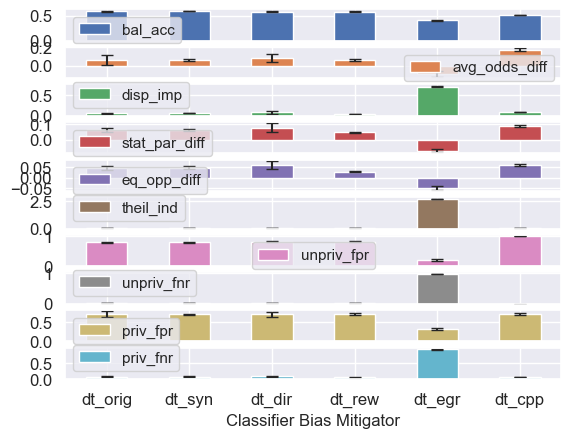

In [91]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

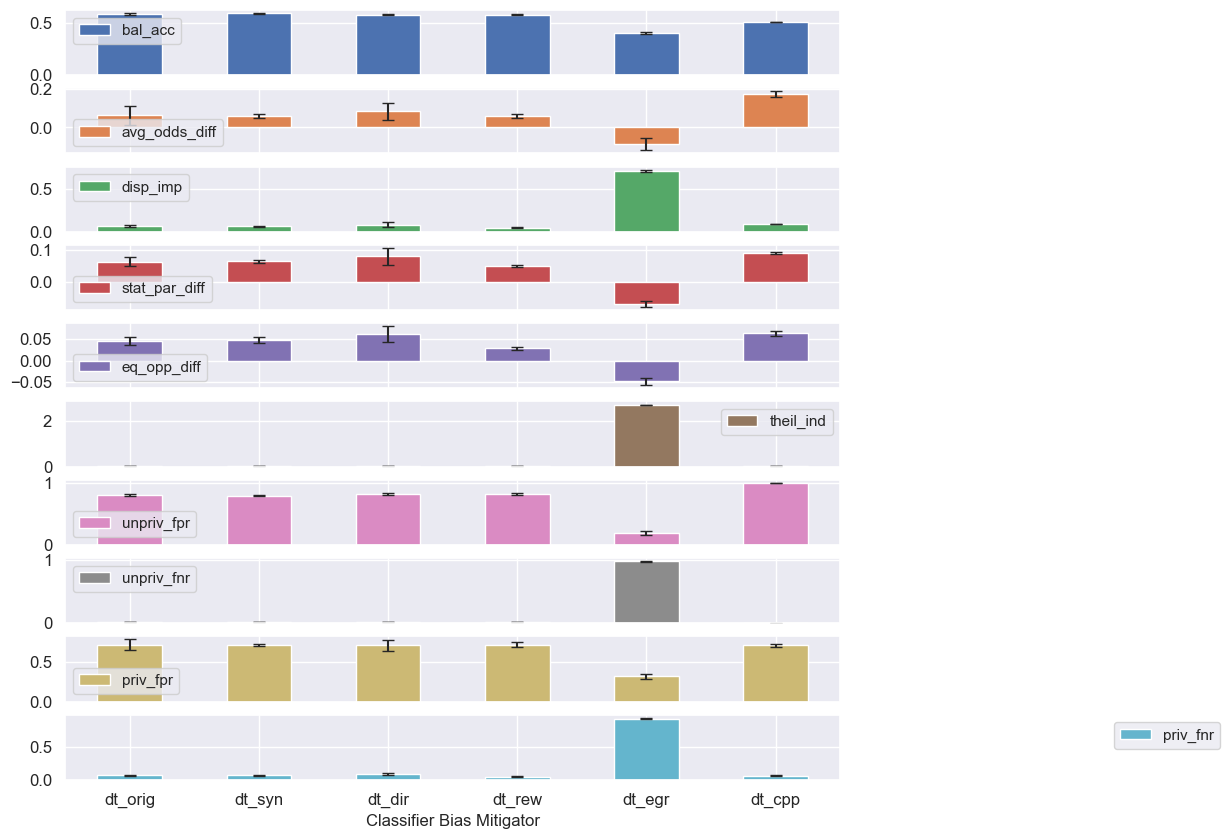

In [92]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [93]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.591686,0.062059,0.064591,0.062702,0.045991,0.035844,0.801879,0.021158,0.723752,0.067149
dt_syn,0.595062,0.059986,0.066360,0.064390,0.047416,0.036036,0.794543,0.021403,0.721987,0.068820
dt_dir,0.583387,0.083106,0.082017,0.079665,0.062157,0.038269,0.819921,0.022735,0.715866,0.084892
dt_rew,0.584723,0.060463,0.049415,0.048032,0.028397,0.034999,0.818871,0.020771,0.726342,0.049168
dt_egr,0.406348,-0.086947,0.712321,-0.071130,-0.048843,2.709719,0.196394,0.979228,0.321445,0.930385
dt_cpp,0.514550,0.174064,0.089630,0.089630,0.063171,0.018515,1.000000,0.000000,0.715042,0.063171


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [94]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [95]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.517822,0.691633,0.512176,0.690446,0.511620,0.719512,0.536046
syn,0.517710,0.693873,0.511922,0.694014,0.511554,0.711685,0.536044
dir,0.523576,0.694576,0.519936,0.690298,0.519406,0.750299,0.554226
rew,0.517181,0.700192,0.512479,0.700730,0.511819,0.707711,0.537793
egr,0.518832,0.644519,0.513999,0.649856,0.513267,0.653863,0.531174


In [96]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [97]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [98]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.690446,0.511620,0.719512,0.536046
syn,0.694014,0.511554,0.711685,0.536044
dir,0.690298,0.519406,0.750299,0.554226
rew,0.700730,0.511819,0.707711,0.537793
egr,0.649856,0.513267,0.653863,0.531174


<Axes: xlabel='Classifier MIA Attacks'>

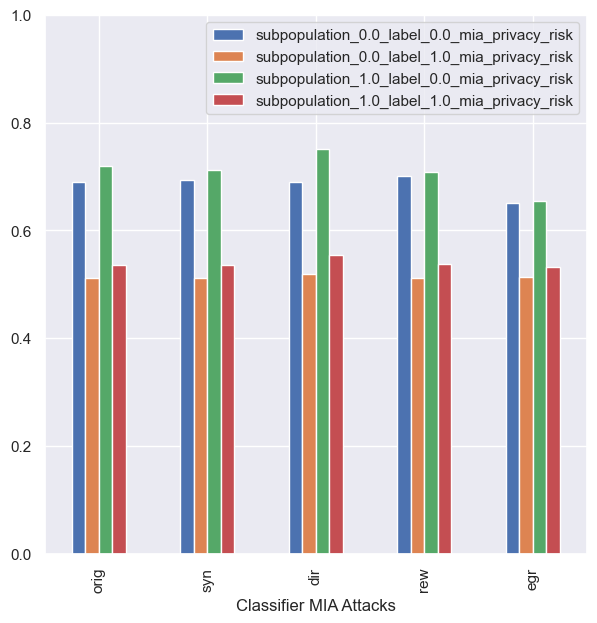

In [99]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [100]:
# Tabular Format
# importing the modules
from tabulate import tabulate

# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.690446  0.694014  0.690298  0.70073   0.649856
subpopulation_0.0_label_1.0_mia_privacy_risk  0.51162   0.511554  0.519406  0.511819  0.513267
subpopulation_1.0_label_0.0_mia_privacy_risk  0.719512  0.711685  0.750299  0.707711  0.653863
subpopulation_1.0_label_1.0_mia_privacy_risk  0.536046  0.536044  0.554226  0.537793  0.531174


### Visualizing using novel technique

In [101]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [102]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [103]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517502
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517982
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.685554
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.694673
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.628159
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.628159
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.535422
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.529050


In [104]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517502
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517982
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.683260
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.694039
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.628159
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.628159
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.535422
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.529050


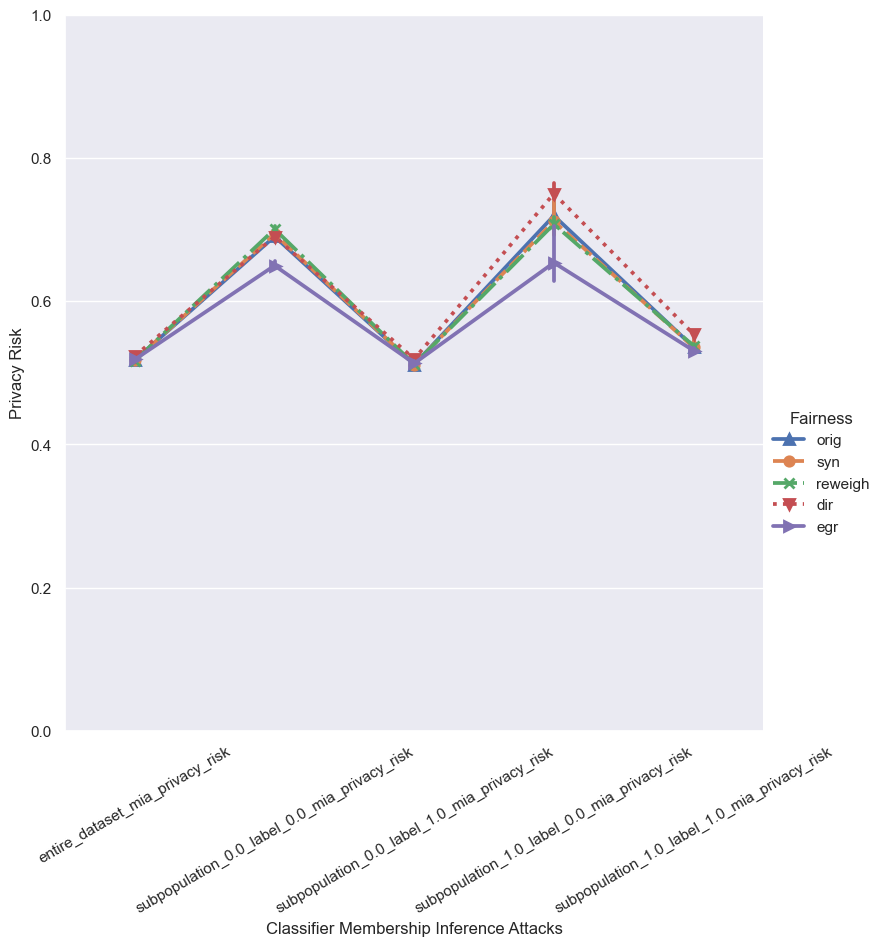

In [105]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [106]:
from sklearn.metrics import RocCurveDisplay, auc

In [107]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

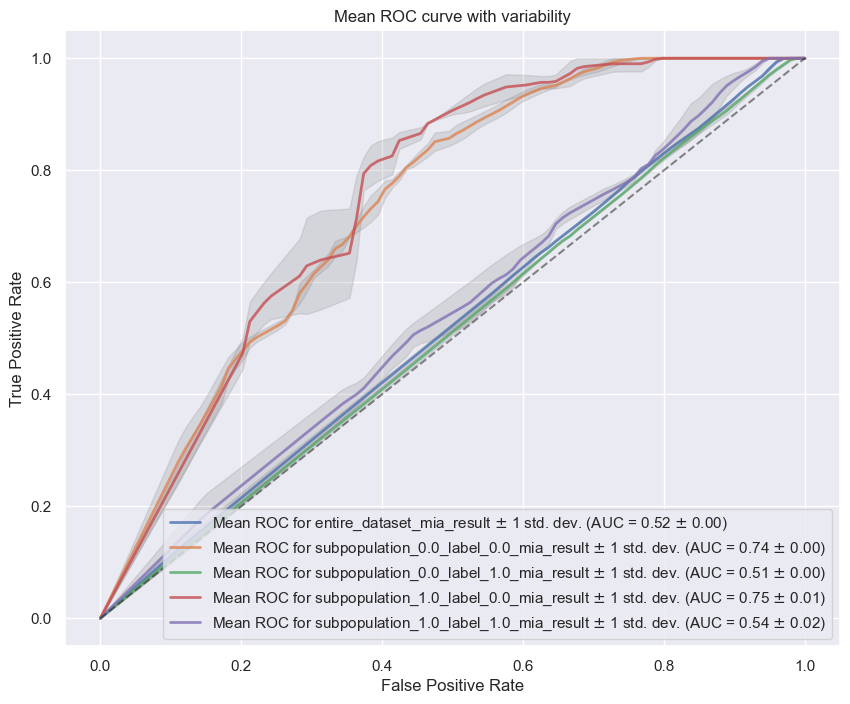

In [108]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []

    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)

    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())

    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

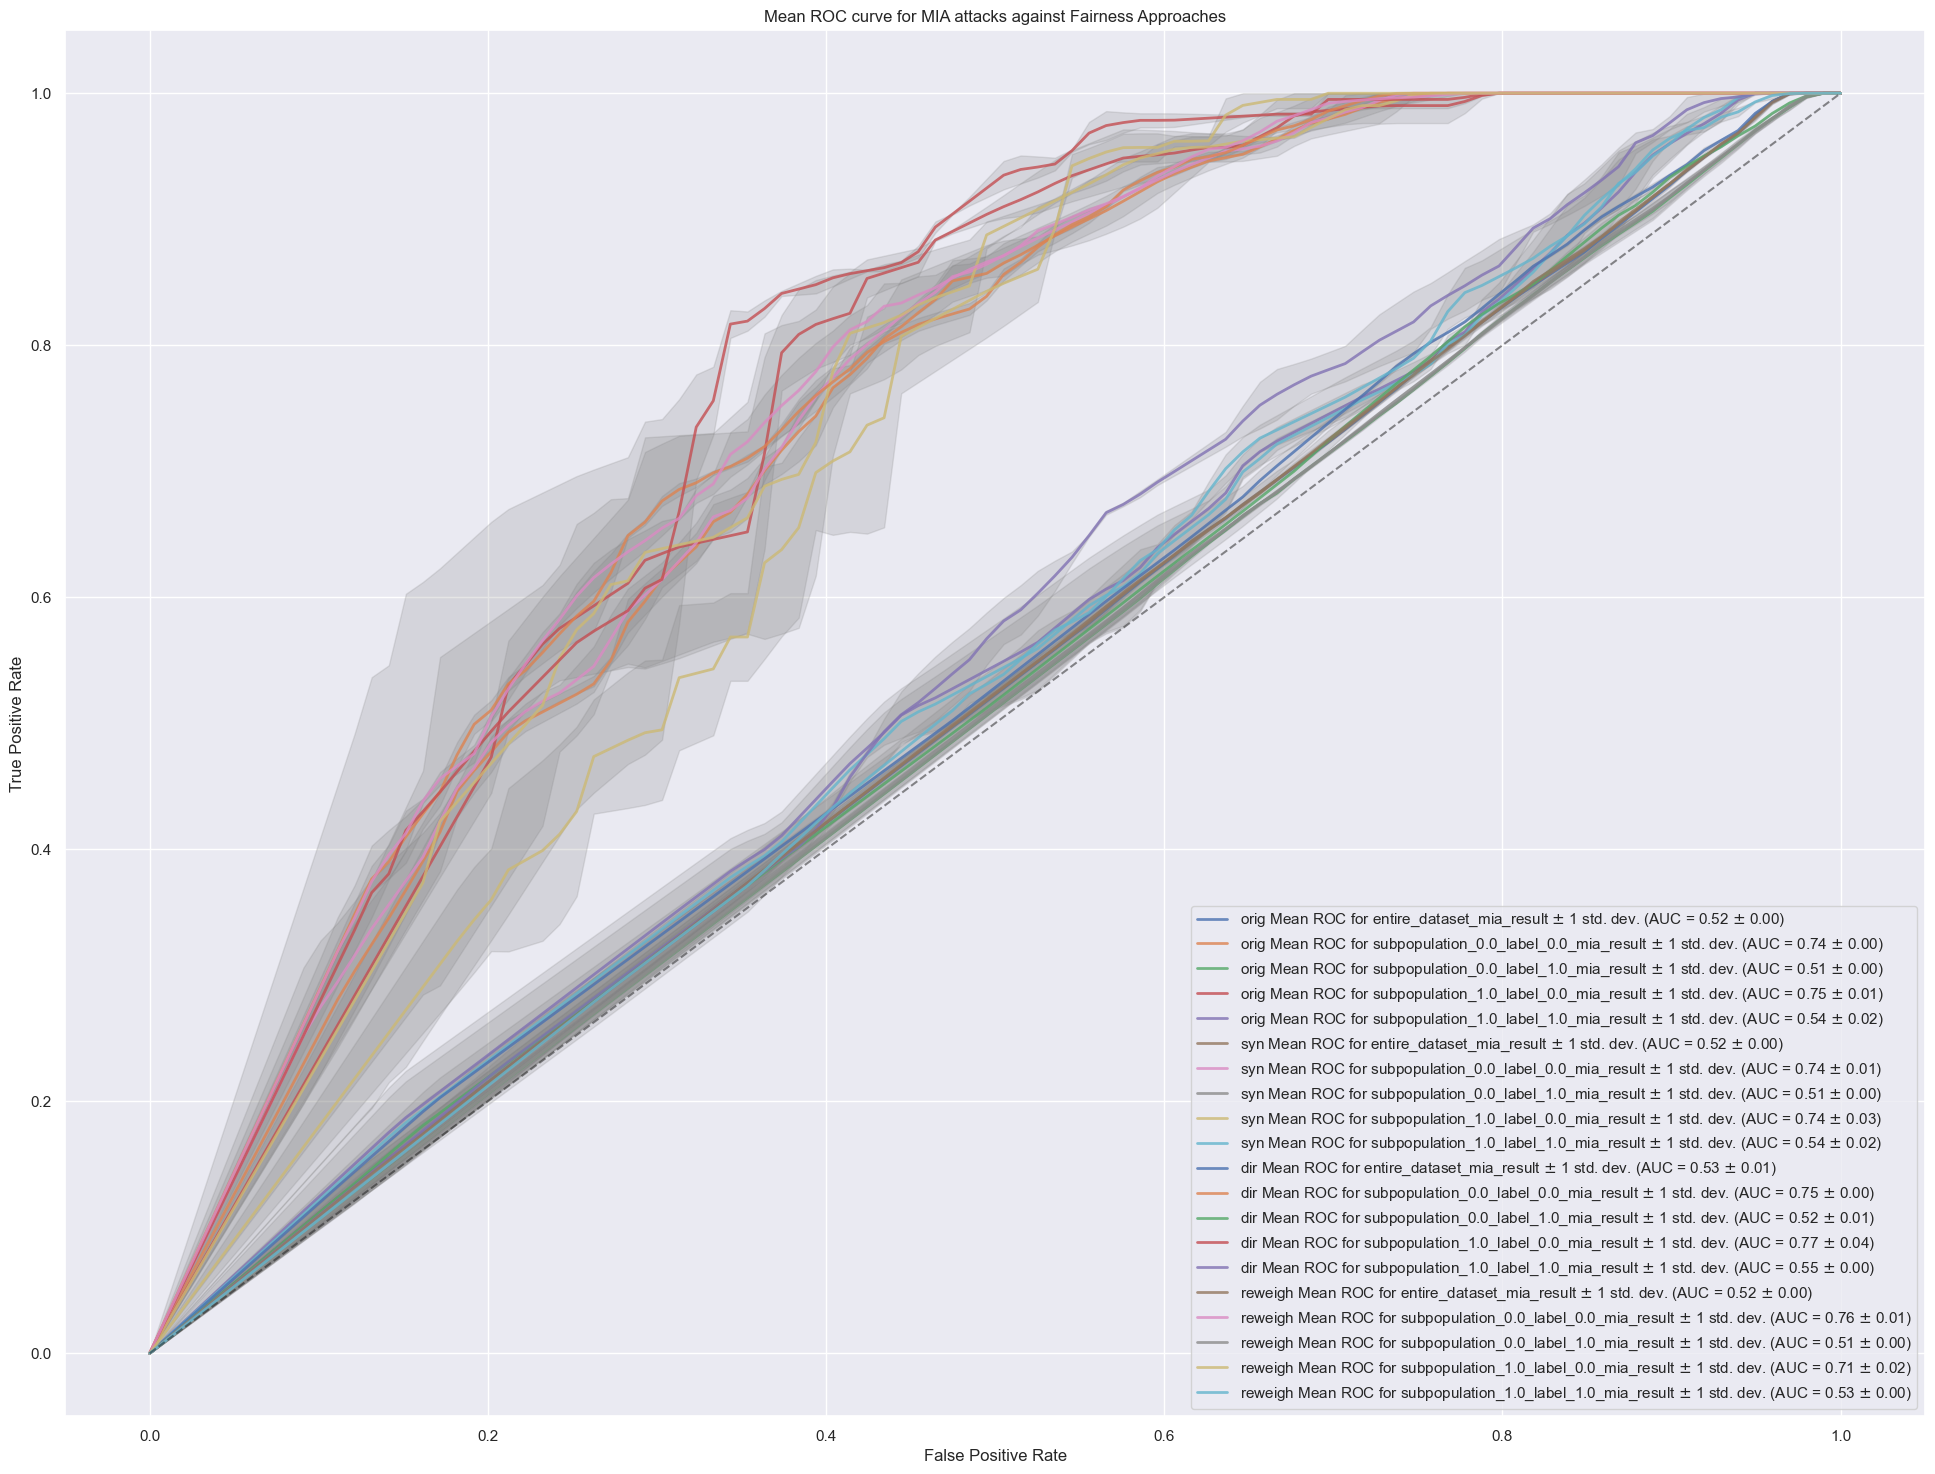

In [109]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:

        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

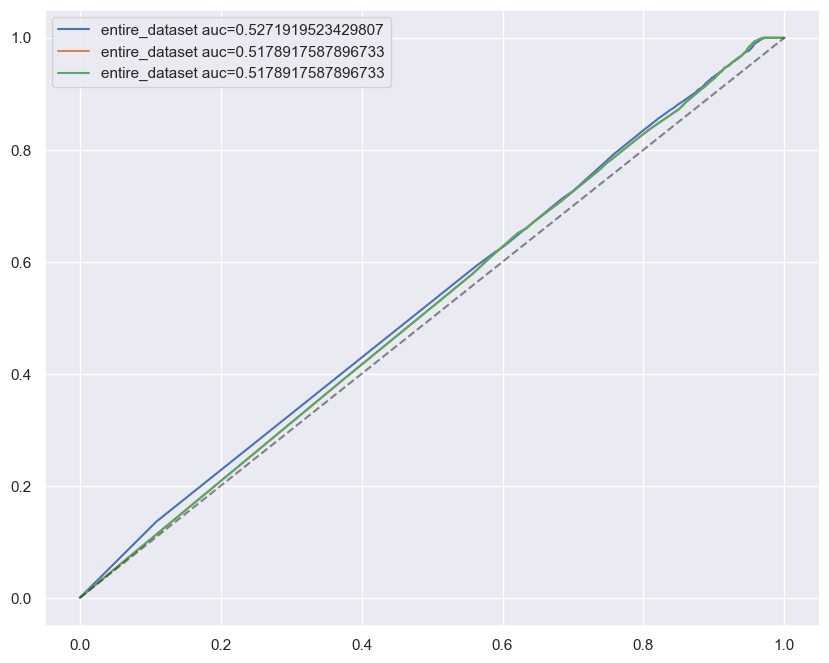

In [110]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart

In [111]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [112]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5209918233074425,
 'entire_dataset_label_0.0_mia_auc': 0.73876466875132,
 'entire_dataset_label_1.0_mia_auc': 0.5129049647626014,
 'subpopulation_0.0_label_0.0_mia_auc': 0.7371654348675962,
 'subpopulation_0.0_label_1.0_mia_auc': 0.5117598243870025,
 'subpopulation_1.0_label_0.0_mia_auc': 0.7503560681260312,
 'subpopulation_1.0_label_1.0_mia_auc': 0.5395264184935192}

In [113]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.520992,0.738765,0.512905,0.737165,0.511760,0.750356,0.539526
syn,0.521366,0.741681,0.512988,0.741922,0.512004,0.740859,0.536538
dir,0.530197,0.753421,0.521523,0.751717,0.520737,0.769051,0.548734
rew,0.521107,0.750890,0.513351,0.755858,0.512830,0.707303,0.532357


<Axes: xlabel='Classifier MIA Attacks'>

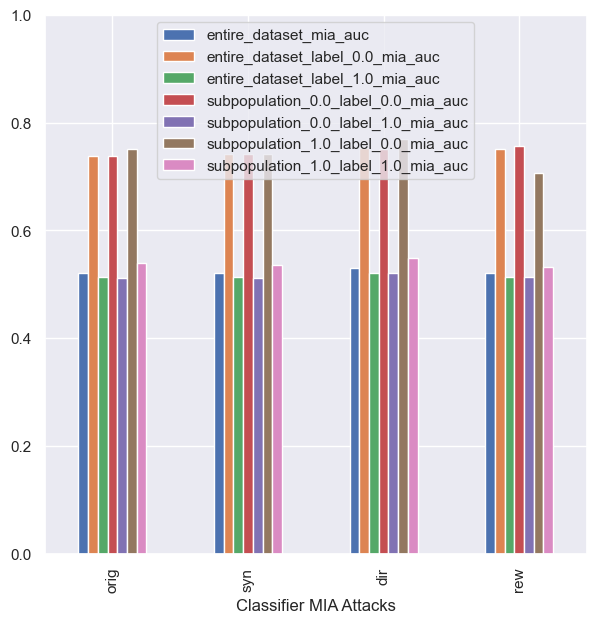

In [114]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [115]:
# Creating data structures to plot point categorical plot from seaborn

In [116]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}

In [117]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.03500336570824125,
  0.03596499663429176,
  0.03596499663429176],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.37110871647509575,
  0.3893451720310766,
  0.3893451720310766],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.03109135369927951,
  0.020981009583312615,
  0.020981009583312615],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.36652029073288916,
  0.38807817253648225,
  0.38807817253648225],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.029243089678363865,
  0.020239794875659967,
  0.020239794875659967],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.4779411764705882,
  0.4195658638120725,
  0.4195658638120725],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.10098823472973462,
  0.057644110275689275,
  0.057644110275689275]}

In [118]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.03500336570824125],
 ['orig', 'entire_dataset', 0.03596499663429176],
 ['orig', 'entire_dataset', 0.03596499663429176],
 ['orig', 'entire_dataset_label_0.0', 0.37110871647509575],
 ['orig', 'entire_dataset_label_0.0', 0.3893451720310766],
 ['orig', 'entire_dataset_label_0.0', 0.3893451720310766],
 ['orig', 'entire_dataset_label_1.0', 0.03109135369927951],
 ['orig', 'entire_dataset_label_1.0', 0.020981009583312615],
 ['orig', 'entire_dataset_label_1.0', 0.020981009583312615],
 ['orig', 'subpopulation_0.0_label_0.0', 0.36652029073288916],
 ['orig', 'subpopulation_0.0_label_0.0', 0.38807817253648225],
 ['orig', 'subpopulation_0.0_label_0.0', 0.38807817253648225],
 ['orig', 'subpopulation_0.0_label_1.0', 0.029243089678363865],
 ['orig', 'subpopulation_0.0_label_1.0', 0.020239794875659967],
 ['orig', 'subpopulation_0.0_label_1.0', 0.020239794875659967],
 ['orig', 'subpopulation_1.0_label_0.0', 0.4779411764705882],
 ['orig', 'subpopulation_1.0_label_0.0', 0.4195

In [119]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.035003
1,orig,entire_dataset,0.035965
2,orig,entire_dataset,0.035965
3,orig,entire_dataset_label_0.0,0.371109
4,orig,entire_dataset_label_0.0,0.389345
...,...,...,...
79,dir,subpopulation_1.0_label_0.0,0.485578
80,dir,subpopulation_1.0_label_0.0,0.485578
81,dir,subpopulation_1.0_label_1.0,0.103207
82,dir,subpopulation_1.0_label_1.0,0.111073


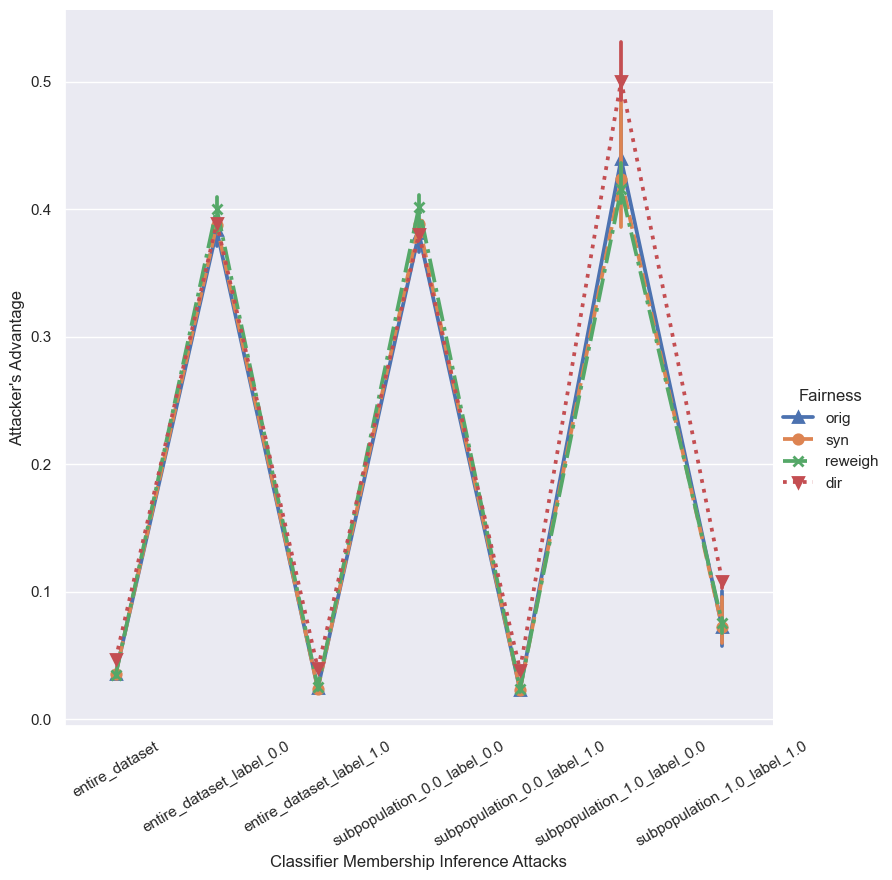

In [120]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


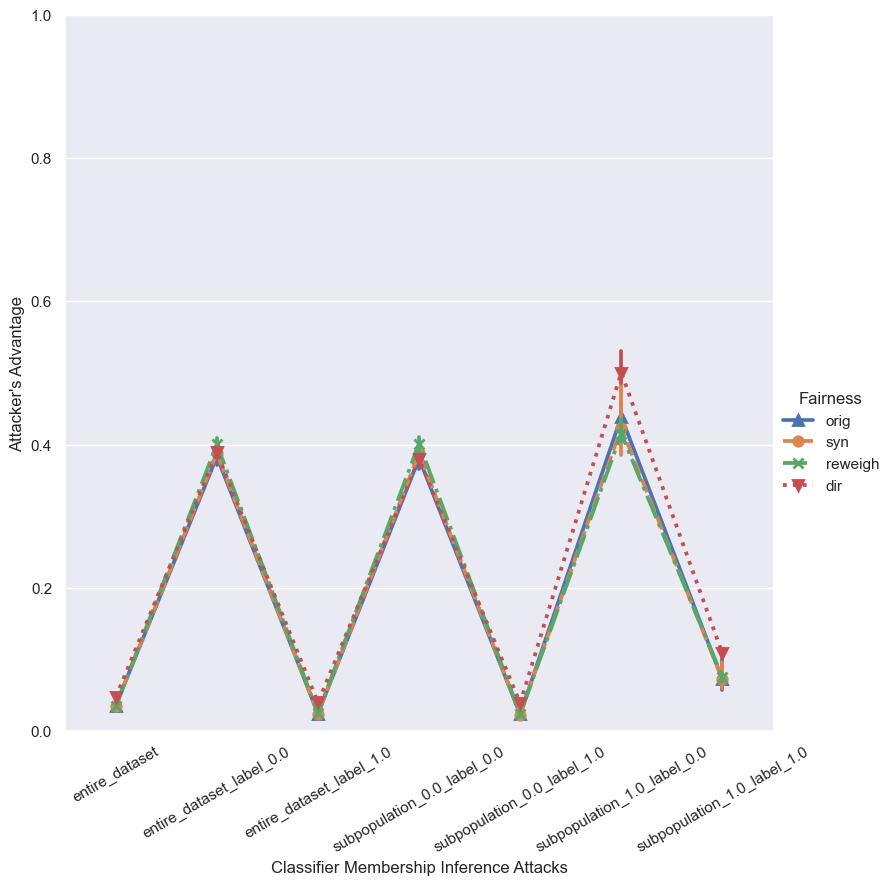

In [121]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [122]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.035003,0.371109,0.031091,0.366520,0.029243,0.477941,0.100988
1,0.035965,0.389345,0.020981,0.388078,0.020240,0.419566,0.057644
2,0.035965,0.389345,0.020981,0.388078,0.020240,0.419566,0.057644


In [123]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}


In [124]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.03564445299227492,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.38326635351241634,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.024351124288634913,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.3808922119352845,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.02324089314322793,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.4390243013649111,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.07209215176037105}

In [125]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.035644,0.383266,0.024351,0.380892,0.023241,0.439024,0.072092
syn,0.035420,0.387746,0.023844,0.388027,0.023107,0.423370,0.072088
dir,0.047152,0.389153,0.039873,0.380597,0.038812,0.500598,0.108451
rew,0.034362,0.400384,0.024958,0.401460,0.023638,0.415422,0.075586


<Axes: xlabel='Classifier MIA Attacks'>

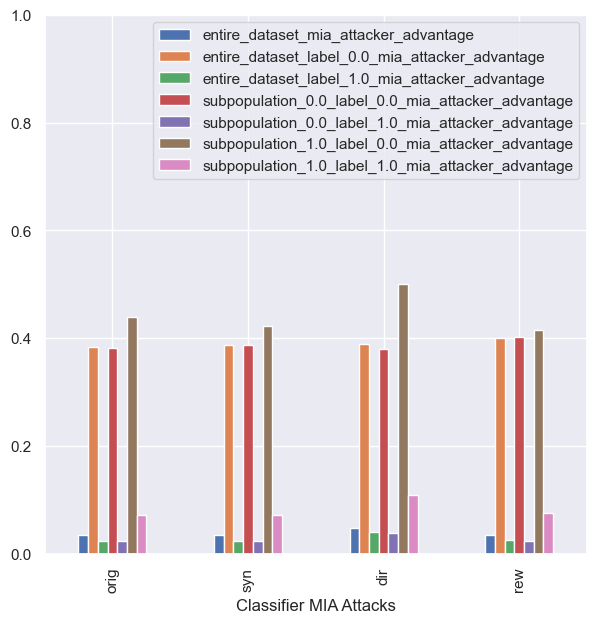

In [126]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [127]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}

In [128]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5560361777428234],
 ['orig', 'entire_dataset', 0.511522478277295],
 ['orig', 'entire_dataset', 0.511522478277295],
 ['orig', 'entire_dataset_label_0.0', 0.7859778597785978],
 ['orig', 'entire_dataset_label_0.0', 0.7117117117117118],
 ['orig', 'entire_dataset_label_0.0', 0.7117117117117118],
 ['orig', 'entire_dataset_label_1.0', 0.5292050944224858],
 ['orig', 'entire_dataset_label_1.0', 0.5069997679634929],
 ['orig', 'entire_dataset_label_1.0', 0.5069997679634929],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7863636363636364],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7133105802047781],
 ['orig', 'subpopulation_0.0_label_0.0', 0.7133105802047781],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5238095238095238],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5062220804084238],
 ['orig', 'subpopulation_0.0_label_1.0', 0.5062220804084238],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7959183673469388],
 ['orig', 'subpopulation_1.0_label_0.0', 0.7],
 ['orig', 'subpopula

In [129]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.556036
1,orig,entire_dataset,0.511522
2,orig,entire_dataset,0.511522
3,orig,entire_dataset_label_0.0,0.785978
4,orig,entire_dataset_label_0.0,0.711712
...,...,...,...
79,dir,subpopulation_1.0_label_0.0,0.701493
80,dir,subpopulation_1.0_label_0.0,0.701493
81,dir,subpopulation_1.0_label_1.0,0.537234
82,dir,subpopulation_1.0_label_1.0,0.554028


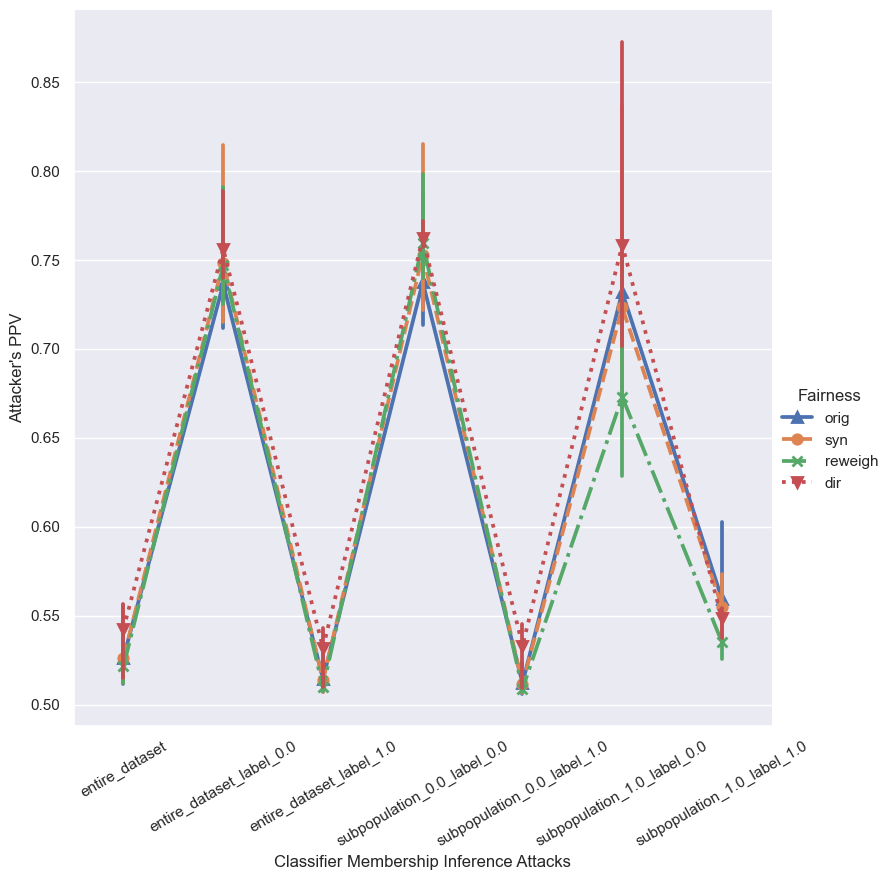

In [130]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [131]:
import pandas as pd

In [132]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,decile3,decile1,race,cluster,lsat,ugpa,dob_yr,fulltime,fam_inc,gender,tier,indxgrp,indxgrp2,labels
0,10.0,10.0,0.0,1.0,44.0,3.5,69.0,1.0,5.0,0.0,4.0,6.0,8.0,1.0
1,4.0,5.0,0.0,2.0,29.0,3.5,69.0,1.0,4.0,0.0,2.0,5.0,5.0,1.0
2,7.0,8.0,0.0,1.0,37.0,3.4,68.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0
3,7.0,8.0,0.0,1.0,43.0,3.3,67.0,1.0,4.0,0.0,4.0,6.0,8.0,1.0
4,2.0,3.0,0.0,4.0,41.0,3.3,64.0,1.0,4.0,0.0,5.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20793,8.0,9.0,0.0,5.0,42.0,3.0,67.0,1.0,4.0,1.0,6.0,6.0,7.0,1.0
20794,9.0,4.0,0.0,3.0,29.5,3.5,68.0,1.0,4.0,1.0,3.0,5.0,5.0,1.0
20795,1.0,1.0,0.0,3.0,33.0,3.1,69.0,1.0,3.0,1.0,3.0,5.0,5.0,0.0
20796,5.0,4.0,0.0,3.0,32.0,3.0,67.0,0.0,3.0,1.0,3.0,5.0,5.0,1.0


In [133]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER)

[INFO]: training decision tree
Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.49      0.66       473
         1.0       0.00      0.00      0.00         0

    accuracy                           0.49       473
   macro avg       0.50      0.25      0.33       473
weighted avg       1.00      0.49      0.66       473

Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      1.00      1.00      9451

    accuracy                           1.00      9451
   macro avg       0.50      0.50      0.50      9451
weighted avg       1.00      1.00      1.00      9451

Classification report for train: 
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69        57
         1.0       0.00      0.00      0.00         0

    accuracy                           0.53      

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

{'train_0_0': 0.4904862579281184,
 'train_0_1': 0.997143159454026,
 'train_1_0': 0.5263157894736842,
 'train_1_1': 0.992822966507177,
 'test_0_0': 0.2106430155210643,
 'test_0_1': 0.9812434141201265,
 'test_1_0': 0.23728813559322035,
 'test_1_1': 0.9423558897243107}

In [134]:
df[["age", "labels"]].value_counts(normalize=True)

KeyError: "['age'] not in index"

In [ ]:
df.drop_duplicates()